In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import networkx as nx

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
PLT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

<h2><center>Extract Karate Club dataset

In [2]:
def get_classes(graph):
    communities = nx.algorithms.community.modularity_max.greedy_modularity_communities(graph)
    classes = np.zeros(len(adj_matrix))
    for i,community in enumerate(communities):
        for individual in community:
            classes[individual] = i   
        communities[i] = list(communities[i])
    
    return communities, classes

graph = nx.karate_club_graph()
adj_matrix = np.array(nx.adjacency_matrix(graph).toarray(),dtype=float)
communities, classes = get_classes(graph)

<h2><center>Define Model

In [3]:
class TradeoffGraphLayer(nn.Module):
    def __init__(self,adjacency_matrix,input_size,output_size):
        super(TradeoffGraphLayer,self).__init__()
        
        self.A = torch.Tensor(adjacency_matrix).requires_grad_(False)
        self.tradeoff_param = nn.Parameter(torch.rand(1),requires_grad=True)
        self.W = nn.Parameter(torch.randn(input_size,output_size,requires_grad=True).float())
        
    def forward(self,X):        
        Ahat = self.A + self.tradeoff_param*torch.eye(len(self.A))
        
        Dhat = torch.diag(1/torch.sqrt(torch.sum(Ahat,dim=0))).float()
        
        return Dhat @ Ahat @ Dhat @  X @ self.W  # X has dimensions (batch_size,node_index,data)
    
class SaveLayer(nn.Module):
    def __init__(self,save_to_this):
        super(SaveLayer, self).__init__()
        self.save_list = save_to_this
    def forward(self, x):
        self.save_list.append(x.cpu().detach().numpy())
        return x

    
class TradeOffGCN(nn.Module):
    def __init__(self, adjacency_matrix,input_size,hidden_size,embedding_size,output_size):
        super(TradeOffGCN,self).__init__()
        
        self.A = adjacency_matrix
        self.graphlayer1 = TradeoffGraphLayer(self.A,input_size,hidden_size)
        self.graphlayer2 = TradeoffGraphLayer(self.A,hidden_size,embedding_size)
        self.graphlayer3 = TradeoffGraphLayer(self.A,embedding_size,output_size)
        
    def forward(self,X):
        X = torch.tanh(self.graphlayer1(X))
        X_embedding = torch.tanh(self.graphlayer2(X))
        X = F.log_softmax(self.graphlayer3(X_embedding), dim=1)
        return X, X_embedding
        

<h2><center> Select labeled nodes with a mask

In [4]:
labeled_indices = []
for community in communities:
    labeled_indices.append(np.random.choice(community))

mask = torch.Tensor([ 1 if i in labeled_indices else 0 for i in range(len(adj_matrix))]).byte()

Y = torch.Tensor(classes).long().to(device)
Y_labeled = Y[mask]

<h2><center>Train Model

In [5]:
def train_model(model,inputs,mask,optim,criterion,epochs):
    losses = np.zeros(epochs)
    total_losses = np.zeros(epochs)
    accuracies = np.zeros(epochs)
    total_accuracies = np.zeros(epochs)

    for epoch in range(epochs):
        print("Epoch [{}/{}] ".format(epoch+1,epochs),end="\r")

        model.zero_grad()

        pred, embedding = model(X)
        labeled_pred = pred[mask]

        loss = criterion(labeled_pred,Y_labeled)
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss = criterion(pred,Y)
        
            losses[epoch] = loss.item()
            total_losses[epoch] = total_loss.item()

            total_preds = np.argmax(pred.detach().numpy(),axis=1)
            total_reals = Y.detach().numpy()

            preds = np.argmax(labeled_pred.detach().numpy(),axis=1)
            reals = Y_labeled.detach().numpy()

            total_accuracies[epoch] = np.sum(total_preds == total_reals)/len(total_preds)
            accuracies[epoch] = np.sum(preds == reals)/len(preds)
            
            embeddings.append(embedding.cpu().detach().numpy())
    return losses, total_losses, accuracies, total_accuracies, embeddings

def plot_embeddings(embeddings):
    
    marker = "P"
    point_size = 20
    marker_size = 200
    marker_alpha = 0.3
    window_size = 1.1
    
    h_plots = 4
    v_plots = 2

    community_colors = [None]*adj_matrix.shape[0]
    for node in range(len(classes)):
        community_colors[node] = PLT_COLORS[int(classes[node])]

    fig, axes = plt.subplots(v_plots,h_plots, sharex=True, sharey=True,figsize=(15,7.5))
    fig.subplots_adjust(wspace=0,hspace=0)
    for i, ax in enumerate(axes.flatten()):
        for l_node in labeled_indices:
            time = int(len(embeddings)*i/(h_plots*v_plots-1))
            if time == len(embeddings):
                time = len(embeddings) - 1
            ax.scatter(embeddings[time][l_node,0],embeddings[time][l_node,1],
                       color="k",s=marker_size,alpha=marker_alpha,marker=marker)

        for node1 in range(len(adj_matrix)):
            for node2 in range(node1,len(adj_matrix)):
                if node1 != node2:
                    if adj_matrix[node1,node2] != 0:
                        ax.plot([embeddings[time][node1,0],embeddings[time][node2,0]],
                                [embeddings[time][node1,1],embeddings[time][node2,1]],
                                color="k",zorder=0,alpha=0.05)

        ax.scatter(embeddings[time][:,0],embeddings[time][:,1],color=community_colors,s=point_size)
        ax.text(0,0.9,str(time if time != 499 else 500)+ " iterations",horizontalalignment='center')
        ax.set_xlim(-window_size,window_size)
        ax.set_ylim(-window_size,window_size)

def plot_loss_accuracy(losses,total_losses,accuracies,total_accuracies):

    fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(15,5))
    fig.subplots_adjust(hspace=0.008)

    ax1.plot(losses,label="On labeled nodes")
    ax1.plot(total_losses,label="On all nodes")
    ax1.legend()
    ax1.grid()
    ax1.set_ylabel("Loss")

    ax2.plot(accuracies,label="On labeled nodes")
    ax2.plot(total_accuracies,label="On all nodes")
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")



In [8]:
input_size = adj_matrix.shape[0]
hidden_size = 16
embedding_size = 2
output_size = 3
embeddings = []

lambdas = [[],[],[]]

N_EPOCHS = 200

tradeoff_model = TradeOffGCN(adjacency_matrix=adj_matrix,
                             input_size=input_size,
                             hidden_size=hidden_size,
                             embedding_size=embedding_size,
                             output_size=output_size)

X = torch.eye(input_size,requires_grad=False)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(tradeoff_model.parameters(),lr=0.01,weight_decay=5e-4)

losses,total_losses,accuracies,total_accuracies,embeddings = train_model( model=tradeoff_model,
                                                                          inputs=X,
                                                                          mask=mask,
                                                                          optim=optimizer,
                                                                          criterion=criterion,
                                                                          epochs=N_EPOCHS)



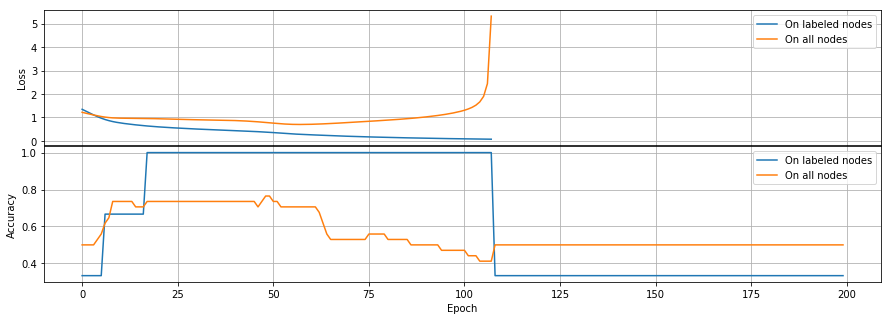

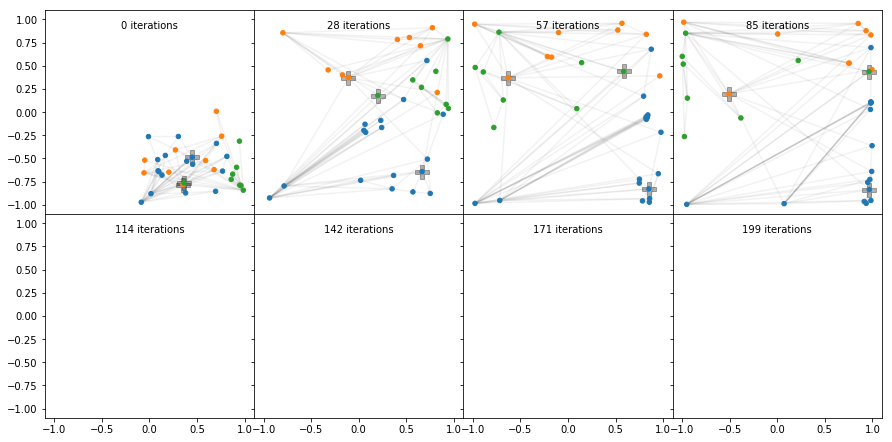

In [9]:
plot_loss_accuracy(losses,total_losses,accuracies,total_accuracies)
plt.savefig("loss_accuracy_IGCN.pdf")
plt.show()

plot_embeddings(embeddings)
plt.savefig("embeddings_IGCN.pdf")
plt.show()